In [ ]:
!pip install transformers
!pip install torch          # For PyTorch
!pip install tensorflow     # For TensorFlow
!pip install numpy
!pip install pandas



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import transformers
import torch
import tensorflow as tf
import numpy as np
import pandas as pd

import seaborn as sns


In [ ]:
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('wietsedv/bert-base-dutch-cased')
model = BertModel.from_pretrained('wietsedv/bert-base-dutch-cased')


Some weights of the model checkpoint at wietsedv/bert-base-dutch-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at wietsedv/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.poo

In [ ]:
import pandas as pd

simlex = pd.read_csv('/content/sample_data/SimLex-999-Dutch-final.txt', sep='\t')


In [ ]:
from transformers import BertModel, BertTokenizer
import torch
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr


Some weights of the model checkpoint at wietsedv/bert-base-dutch-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at wietsedv/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.poo

Layer 0 - Spearman correlation: 0.280
Layer 1 - Spearman correlation: 0.216
Layer 2 - Spearman correlation: 0.218
Layer 3 - Spearman correlation: 0.226
Layer 4 - Spearman correlation: 0.212
Layer 5 - Spearman correlation: 0.219
Layer 6 - Spearman correlation: 0.211
Layer 7 - Spearman correlation: 0.189
Layer 8 - Spearman correlation: 0.182
Layer 9 - Spearman correlation: 0.175
Layer 10 - Spearman correlation: 0.168
Layer 11 - Spearman correlation: 0.180
Layer 12 - Spearman correlation: 0.224


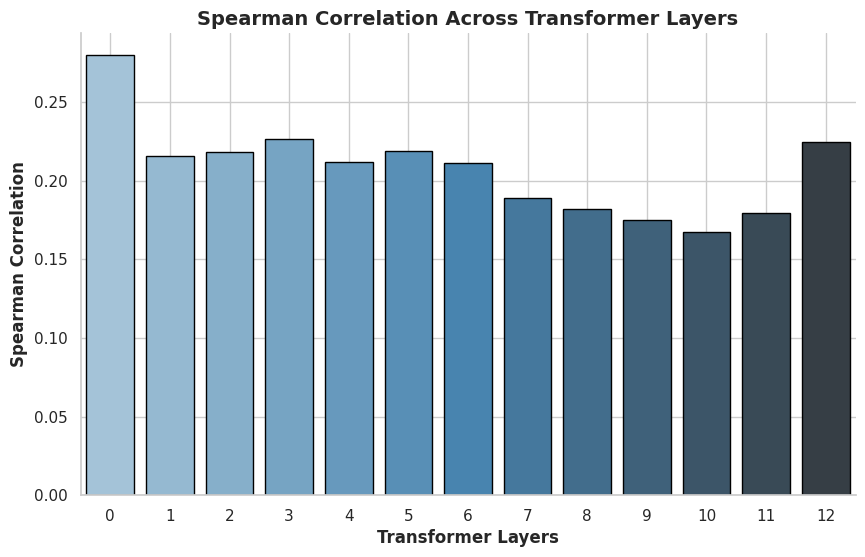

In [ ]:
from transformers import BertModel, BertTokenizer
import torch
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns



# Load the pre-trained model and the tokenizer
tokenizer = BertTokenizer.from_pretrained('wietsedv/bert-base-dutch-cased')
model = BertModel.from_pretrained('wietsedv/bert-base-dutch-cased', output_hidden_states=True)

def get_word_embedding(word, layer_num):
    inputs = tokenizer(word, return_tensors='pt')
    outputs = model(**inputs)
    # Use the hidden state from the specified layer as word embedding
    embeddings = outputs.hidden_states[layer_num]
    # Get the mean of the token vectors
    word_embedding = torch.mean(embeddings[0], dim=0)
    # Detach the tensor from the computational graph before converting into a numpy array
    word_embedding = word_embedding.detach().numpy()
    return word_embedding

def calculate_similarity(word1, word2, layer_num):
    word1_embedding = get_word_embedding(word1, layer_num)
    word2_embedding = get_word_embedding(word2, layer_num)
    similarity = 1 - cosine(word1_embedding, word2_embedding)
    return similarity

spearman_results = []  # A list to store the Spearman correlations

for layer_num in range(13):  # For BERT base models, there are 13 layers including the output layer
    similarity_scores = []
    for _, row in simlex.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_num)
        similarity_scores.append(similarity)

    simlex[f'predicted_similarity_layer_{layer_num}'] = similarity_scores

    # Assuming 'SimLex999' column contains the true similarity scores
    correlation, _ = spearmanr(simlex['SimLex999'], simlex[f'predicted_similarity_layer_{layer_num}'])
    spearman_results.append(correlation)
    print(f'Layer {layer_num} - Spearman correlation: {correlation:.3f}')

# Plotting
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=list(range(13)), y=spearman_results, palette="Blues_d", ax=ax, edgecolor='black')
ax.set_title('Spearman Correlation Across Transformer Layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Transformer Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')
ax.grid(True)
sns.despine()
plt.show()


In [ ]:
from transformers import BertModel, BertTokenizer
import torch
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr

# Load the pre-trained model and the tokenizer
tokenizer = BertTokenizer.from_pretrained('wietsedv/bert-base-dutch-cased')
model = BertModel.from_pretrained('wietsedv/bert-base-dutch-cased', output_hidden_states=True)

def get_word_embedding(word, layer_nums):
    inputs = tokenizer(word, return_tensors='pt')
    outputs = model(**inputs)
    # Use the hidden state from the specified layers as word embedding
    embeddings = [outputs.hidden_states[i] for i in layer_nums]
    # Average the embeddings from the specified layers
    averaged_embedding = torch.mean(torch.stack(embeddings), dim=0)
    # Get the mean of the token vectors
    word_embedding = torch.mean(averaged_embedding[0], dim=0)
    # Detach the tensor from the computational graph before converting into a numpy array
    word_embedding = word_embedding.detach().numpy()
    return word_embedding

def calculate_similarity(word1, word2, layer_nums):
    word1_embedding = get_word_embedding(word1, layer_nums)
    word2_embedding = get_word_embedding(word2, layer_nums)
    similarity = 1 - cosine(word1_embedding, word2_embedding)
    return similarity

# Specify the layers you want to combine
layer_nums = [0, 3]

similarity_scores = []
for _, row in simlex.iterrows():
    word1 = row['word1']
    word2 = row['word2']
    similarity = calculate_similarity(word1, word2, layer_nums)
    similarity_scores.append(similarity)

simlex['predicted_similarity'] = similarity_scores

# Assuming 'SimLex999' column contains the true similarity scores
correlation, _ = spearmanr(simlex['SimLex999'], simlex['predicted_similarity'])
print(f'Layers {layer_nums} - Spearman correlation: {correlation:.3f}')


Some weights of the model checkpoint at wietsedv/bert-base-dutch-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at wietsedv/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.poo

Layers [0, 3] - Spearman correlation: 0.276


In [ ]:
# similarity_scores = []
# for _, row in simlex.iterrows():
#     word1 = row['word1']
#     word2 = row['word2']
#     similarity = calculate_similarity(word1, word2)
#     similarity_scores.append(similarity)

# simlex['predicted_similarity'] = similarity_scores

In [ ]:
from scipy.stats import spearmanr

# Assuming 'SimLex999' column contains the true similarity scores
correlation, _ = spearmanr(simlex['SimLex999'], simlex['predicted_similarity'])
print(f'Spearman correlation: {correlation:.3f}')


Spearman correlation: 0.276


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object that will scale values to range from 0 to 10
scaler = MinMaxScaler(feature_range=(0, 10))

# Fit the scaler on the predicted similarity scores and transform them
simlex['predicted_similarity_scaled'] = scaler.fit_transform(simlex[['predicted_similarity']])


In [ ]:
# Compute absolute differences between predicted and actual scores
simlex['abs_diff'] = abs(simlex['SimLex999'] - simlex['predicted_similarity'])

# Sort by absolute differences
simlex_sorted = simlex.sort_values('abs_diff', ascending=False)

# Print out the word pairs with the largest differences
print(simlex_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity', 'predicted_similarity_scaled']].head(10))


         word1        word2  SimLex999  predicted_similarity  \
370       arts       dokter       9.28              0.873596   
87     angstig         bang       9.06              0.854293   
28   eenvoudig  gemakkelijk       9.04              0.865348   
22        vlug         snel       8.95              0.866623   
840  deelnemen      meedoen       8.90              0.848308   
155   boosheid        woede       8.87              0.831038   
788    creëren        maken       8.76              0.829627   
236    bedrijf  onderneming       8.72              0.899682   
62    cruciaal   belangrijk       8.59              0.797634   
692      beest         dier       8.59              0.844841   

     predicted_similarity_scaled  
370                     8.156351  
87                      7.525533  
28                      7.886815  
22                      7.928462  
840                     7.329946  
155                     6.765587  
788                     6.719476  
236            

In [ ]:
# Group by POS and compute mean difference for each group
grouped = simlex.groupby('POS')['abs_diff'].mean()

# Print out the mean difference for each POS
print(grouped)

POS
A    3.297623
N    2.835776
V    2.725618
Name: abs_diff, dtype: float64


In [ ]:
# Select the adjective pairs with the largest differences
adjectives = simlex[simlex['POS'] == 'A']
adjectives_sorted = adjectives.sort_values('abs_diff', ascending=False)
print('Adjective pairs with largest differences:')
print(adjectives_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity']].head(10))

# Select the noun pairs with the largest differences
nouns = simlex[simlex['POS'] == 'N']
nouns_sorted = nouns.sort_values('abs_diff', ascending=False)
print('\nNoun pairs with largest differences:')
print(nouns_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity']].head(10))

# Select the verb pairs with the largest differences
verbs = simlex[simlex['POS'] == 'V']
verbs_sorted = verbs.sort_values('abs_diff', ascending=False)
print('\nVerb pairs with largest differences:')
print(verbs_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity']].head(10))


Adjective pairs with largest differences:
           word1         word2  SimLex999  predicted_similarity
87       angstig          bang       9.06              0.854293
28     eenvoudig   gemakkelijk       9.04              0.865348
22          vlug          snel       8.95              0.866623
62      cruciaal    belangrijk       8.59              0.797634
59    essentieel  noodzakelijk       8.55              0.817741
25   eigenaardig        vreemd       8.56              0.857524
33          raar        vreemd       8.40              0.901108
52  noodzakelijk    belangrijk       8.22              0.787221
1           slim   intelligent       8.19              0.830950
71         bizar        vreemd       8.11              0.833527

Noun pairs with largest differences:
        word1         word2  SimLex999  predicted_similarity
370      arts        dokter       9.28              0.873596
155  boosheid         woede       8.87              0.831038
236   bedrijf   onderneming      

In [ ]:
pos_categories = ["A", "N", "V"]
for pos in pos_categories:
    pos_data = simlex[simlex['POS'] == pos]
    spearman_corr = pos_data['SimLex999'].corr(pos_data['predicted_similarity'], method='spearman')
    print(f"Spearman correlation for {pos}: {spearman_corr}")


Spearman correlation for A: 0.38389480242547624
Spearman correlation for N: 0.3195469653921415
Spearman correlation for V: 0.0793393737137762


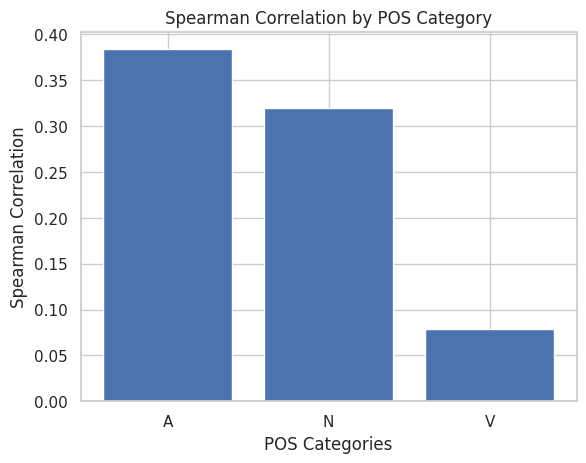

In [ ]:
import matplotlib.pyplot as plt

pos_categories = ["A", "N", "V"]
spearman_corrs = []

for pos in pos_categories:
    pos_data = simlex[simlex['POS'] == pos]
    spearman_corr = pos_data['SimLex999'].corr(pos_data['predicted_similarity'], method='spearman')
    spearman_corrs.append(spearman_corr)

plt.bar(pos_categories, spearman_corrs)
plt.xlabel('POS Categories')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation by POS Category')
plt.show()


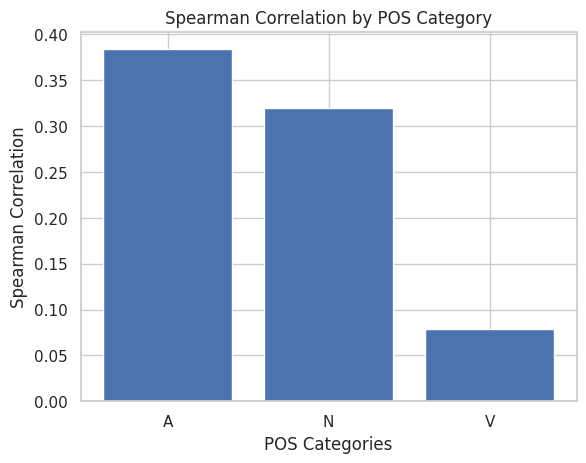

In [ ]:
import matplotlib.pyplot as plt

pos_categories = ["A", "N", "V"]
spearman_corrs = []

for pos in pos_categories:
    pos_data = simlex[simlex['POS'] == pos]
    spearman_corr = pos_data['SimLex999'].corr(pos_data['predicted_similarity'], method='spearman')
    spearman_corrs.append(spearman_corr)

plt.bar(pos_categories, spearman_corrs)
plt.xlabel('POS Categories')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation by POS Category')
plt.show()


In [ ]:
simlex['abs_diff'] = abs(simlex['SimLex999'] - simlex['predicted_similarity'])
largest_diff = simlex.nlargest(10, 'abs_diff')
print(largest_diff)


         word1        word2  SimLex999 POS  predicted_similarity_layer_0  \
370       arts       dokter       9.28   N                      0.848842   
87     angstig         bang       9.06   A                      0.809990   
28   eenvoudig  gemakkelijk       9.04   A                      0.847455   
22        vlug         snel       8.95   A                      0.875864   
840  deelnemen      meedoen       8.90   V                      0.774612   
155   boosheid        woede       8.87   N                      0.753876   
788    creëren        maken       8.76   V                      0.776372   
236    bedrijf  onderneming       8.72   N                      0.852805   
62    cruciaal   belangrijk       8.59   A                      0.731705   
692      beest         dier       8.59   N                      0.839207   

     predicted_similarity_layer_1  predicted_similarity_layer_2  \
370                      0.855517                      0.882763   
87                       0.82

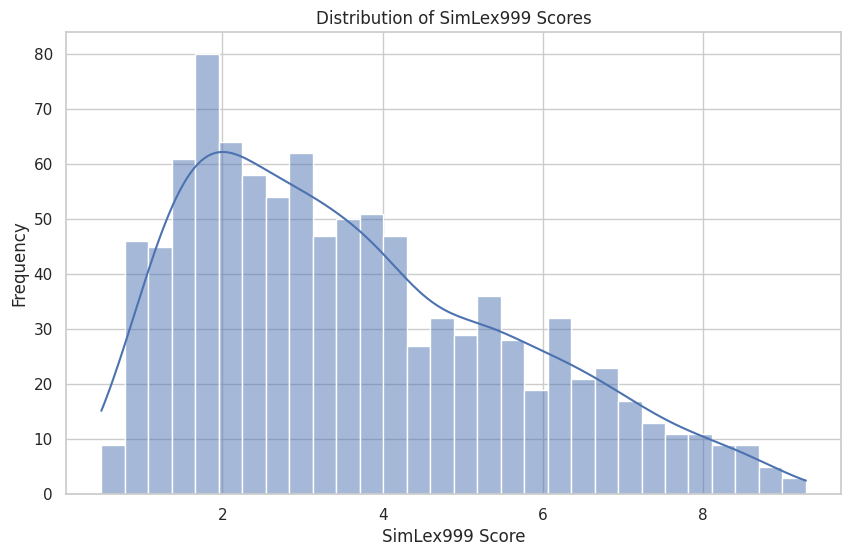

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram for SimLex999 scores
plt.figure(figsize=(10,6))
sns.histplot(data=simlex, x="SimLex999", bins=30, kde=True)
plt.title("Distribution of SimLex999 Scores")
plt.xlabel("SimLex999 Score")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Lees de SUBTLEX-NL gegevens
subtlex_nl = pd.read_csv('/content/sample_data/SUBTLEX-NL-New.txt', sep='\t')

# Maak een woordenboek dat de frequentie van elk woord opslaat
word_frequencies = subtlex_nl.set_index('Word')['FREQcount'].to_dict()

# Nu kun je de frequenties uit dit woordenboek gebruiken in plaats van de willekeurige frequenties


<ipython-input-19-03d59771aca7>:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  subtlex_nl = pd.read_csv('/content/sample_data/SUBTLEX-NL-New.txt', sep='\t')


In [ ]:
# Add frequency data to SimLex999 DataFrame
simlex['frequency1'] = simlex['word1'].map(word_frequencies)
simlex['frequency2'] = simlex['word2'].map(word_frequencies)

# Calculate median frequency
median_freq = simlex[['frequency1', 'frequency2']].median().mean()

# Split into high frequency and low frequency subsets
simlex_high_freq = simlex[(simlex['frequency1'] > median_freq) & (simlex['frequency2'] > median_freq)]
simlex_low_freq = simlex[(simlex['frequency1'] <= median_freq) & (simlex['frequency2'] <= median_freq)]

# Specify the layers you want to combine
layer_nums = [0, 3]

for simlex_subset, freq in zip([simlex_high_freq, simlex_low_freq], ['high', 'low']):
    similarity_scores = []
    for _, row in simlex_subset.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_nums)
        similarity_scores.append(similarity)

    simlex_subset['predicted_similarity'] = similarity_scores

    # Assuming 'SimLex999' column contains the true similarity scores
    correlation, _ = spearmanr(simlex_subset['SimLex999'], simlex_subset['predicted_similarity'])
    print(f'Layers {layer_nums} - Spearman correlation for {freq} frequency words: {correlation:.3f}')


<ipython-input-20-476b002322a5>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simlex_subset['predicted_similarity'] = similarity_scores


Layers [0, 3] - Spearman correlation for high frequency words: 0.375
Layers [0, 3] - Spearman correlation for low frequency words: 0.320


In [ ]:
simlex_high_freq = simlex[(simlex['frequency1'] > median_freq) & (simlex['frequency2'] > median_freq)].copy()
simlex_low_freq = simlex[(simlex['frequency1'] <= median_freq) & (simlex['frequency2'] <= median_freq)].copy()


In [ ]:
# Calculate the Spearman correlation for each layer and each frequency group
for layer_num in range(13):  # For BERT base models, there are 13 layers including the output layer
    similarity_scores_high = []
    similarity_scores_low = []

    for _, row in simlex_high_freq.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, [layer_num])
        similarity_scores_high.append(similarity)

    for _, row in simlex_low_freq.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, [layer_num])
        similarity_scores_low.append(similarity)

    simlex_high_freq['predicted_similarity'] = similarity_scores_high
    simlex_low_freq['predicted_similarity'] = similarity_scores_low

    correlation_high, _ = spearmanr(simlex_high_freq['SimLex999'], simlex_high_freq['predicted_similarity'])
    correlation_low, _ = spearmanr(simlex_low_freq['SimLex999'], simlex_low_freq['predicted_similarity'])

    print(f'Layer {layer_num} - Spearman correlation for high frequency words: {correlation_high:.3f}')
    print(f'Layer {layer_num} - Spearman correlation for low frequency words: {correlation_low:.3f}')


Layer 0 - Spearman correlation for high frequency words: 0.412
Layer 0 - Spearman correlation for low frequency words: 0.280
Layer 1 - Spearman correlation for high frequency words: 0.291
Layer 1 - Spearman correlation for low frequency words: 0.258
Layer 2 - Spearman correlation for high frequency words: 0.289
Layer 2 - Spearman correlation for low frequency words: 0.275
Layer 3 - Spearman correlation for high frequency words: 0.290
Layer 3 - Spearman correlation for low frequency words: 0.289
Layer 4 - Spearman correlation for high frequency words: 0.279
Layer 4 - Spearman correlation for low frequency words: 0.272
Layer 5 - Spearman correlation for high frequency words: 0.304
Layer 5 - Spearman correlation for low frequency words: 0.255
Layer 6 - Spearman correlation for high frequency words: 0.289
Layer 6 - Spearman correlation for low frequency words: 0.254
Layer 7 - Spearman correlation for high frequency words: 0.298
Layer 7 - Spearman correlation for low frequency words: 0.222


In [ ]:
# Get the vocabulary used by the tokenizer
vocab = tokenizer.get_vocab()

# Create an empty set to store out-of-vocabulary (OOV) words
oov_words = set()

# Check each unique word in the SimLex-999 dataset
for word in pd.concat([simlex['word1'], simlex['word2']]).unique():
    if word not in vocab:
        oov_words.add(word)

print(f'There are {len(oov_words)} out-of-vocabulary words.')
print('Some examples are:', list(oov_words)[:10])

# Remove rows in simlex where either 'word1' or 'word2' is an OOV word
simlex_no_oov = simlex[~simlex['word1'].isin(oov_words) & ~simlex['word2'].isin(oov_words)]
print(f'There are {len(simlex_no_oov)} word pairs without OOV words.')


There are 139 out-of-vocabulary words.
Some examples are: ['volwassene', 'demon', "taxi's", 'competentie', 'teen', 'filmrol', 'examineren', 'intrekken', 'bijvoegen', 'cliff']
There are 805 word pairs without OOV words.


In [ ]:
def get_word_embedding(word, layer_nums):
    inputs = tokenizer(word, return_tensors='pt')
    outputs = model(**inputs)
    # Check if layer_nums is a list or a single integer
    if isinstance(layer_nums, int):
        layer_nums = [layer_nums]
    # Use the hidden state from the specified layers as word embedding
    embeddings = [outputs.hidden_states[i] for i in layer_nums]
    # Average the embeddings from the specified layers
    averaged_embedding = torch.mean(torch.stack(embeddings), dim=0)
    # Get the mean of the token vectors
    word_embedding = torch.mean(averaged_embedding[0], dim=0)
    # Detach the tensor from the computational graph before converting into a numpy array
    word_embedding = word_embedding.detach().numpy()
    return word_embedding

def calculate_similarity(word1, word2, layer_nums):
    word1_embedding = get_word_embedding(word1, layer_nums)
    word2_embedding = get_word_embedding(word2, layer_nums)
    similarity = 1 - cosine(word1_embedding, word2_embedding)
    return similarity

# Specify the layers you want to combine
layer_nums = [1, 12]

# Calculate the Spearman correlation for each layer and each frequency group
for layer_num in range(13):  # For RobBERT base models, there are 13 layers including the output layer
    similarity_scores = []  # Initialize similarity_scores in each iteration

    for _, row in simlex_no_oov.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_num)
        similarity_scores.append(similarity)

    simlex_no_oov[f'predicted_similarity_layer_{layer_num}'] = similarity_scores

    correlation, _ = spearmanr(simlex_no_oov['SimLex999'], simlex_no_oov[f'predicted_similarity_layer_{layer_num}'])
    print(f'Layer {layer_num} - Spearman correlation (No OOV): {correlation:.3f}')


<ipython-input-24-d54da9d8529d>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simlex_no_oov[f'predicted_similarity_layer_{layer_num}'] = similarity_scores


Layer 0 - Spearman correlation (No OOV): 0.444
Layer 1 - Spearman correlation (No OOV): 0.296
Layer 2 - Spearman correlation (No OOV): 0.294
Layer 3 - Spearman correlation (No OOV): 0.300
Layer 4 - Spearman correlation (No OOV): 0.294
Layer 5 - Spearman correlation (No OOV): 0.308
Layer 6 - Spearman correlation (No OOV): 0.304
Layer 7 - Spearman correlation (No OOV): 0.268
Layer 8 - Spearman correlation (No OOV): 0.263
Layer 9 - Spearman correlation (No OOV): 0.259
Layer 10 - Spearman correlation (No OOV): 0.253
Layer 11 - Spearman correlation (No OOV): 0.252
Layer 12 - Spearman correlation (No OOV): 0.297


In [ ]:
# Specify the layer you want to compute correlation for
layer_num = 0

# Calculate the Spearman correlation for the specified layer
similarity_scores = []  # Initialize similarity_scores

for _, row in simlex_no_oov.iterrows():
    word1 = row['word1']
    word2 = row['word2']
    similarity = calculate_similarity(word1, word2, layer_num)
    similarity_scores.append(similarity)

simlex_no_oov[f'predicted_similarity_layer_{layer_num}'] = similarity_scores

correlation, _ = spearmanr(simlex_no_oov['SimLex999'], simlex_no_oov[f'predicted_similarity_layer_{layer_num}'])
print(f'Layer {layer_num} - Spearman correlation (No OOV): {correlation:.3f}')


Layer 0 - Spearman correlation (No OOV): 0.444


<ipython-input-25-7da999a8262a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simlex_no_oov[f'predicted_similarity_layer_{layer_num}'] = similarity_scores


In [ ]:
def get_word_embedding(word, layer_nums):
    # Tokenize the word into subtokens
    subtokens = tokenizer.tokenize(word)
    # Encode the subtokens to input IDs and wrap it in a tensor
    input_ids = torch.tensor([tokenizer.convert_tokens_to_ids(subtokens)])
    # Get the model outputs
    outputs = model(input_ids)
    # Check if layer_nums is a list or a single integer
    if isinstance(layer_nums, int):
        layer_nums = [layer_nums]
    # Use the hidden state from the specified layers as word embedding
    embeddings = [outputs.hidden_states[i] for i in layer_nums]
    # Average the embeddings from the specified layers
    averaged_embedding = torch.mean(torch.stack(embeddings), dim=0)
    # Get the mean of the subtoken vectors to get the word vector
    word_embedding = torch.mean(averaged_embedding[0], dim=0)
    # Detach the tensor from the computational graph before converting into a numpy array
    word_embedding = word_embedding.detach().numpy()
    return word_embedding


In [ ]:
def calculate_similarity(word1, word2, layer_nums):
    word1_embedding = get_word_embedding(word1, layer_nums)
    word2_embedding = get_word_embedding(word2, layer_nums)
    similarity = 1 - cosine(word1_embedding, word2_embedding)
    return similarity

# Calculate the Spearman correlation for each layer and each frequency group
for layer_num in range(13):  # For RobBERT base models, there are 13 layers including the output layer
    similarity_scores = []  # Initialize similarity_scores in each iteration

    for _, row in simlex.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_num)
        similarity_scores.append(similarity)

    simlex[f'predicted_similarity_layer_{layer_num}'] = similarity_scores

    correlation, _ = spearmanr(simlex['SimLex999'], simlex[f'predicted_similarity_layer_{layer_num}'])
    print(f'Layer {layer_num} - Spearman correlation (No OOV): {correlation:.3f}')

Layer 0 - Spearman correlation (No OOV): 0.236
Layer 1 - Spearman correlation (No OOV): 0.301
Layer 2 - Spearman correlation (No OOV): 0.337
Layer 3 - Spearman correlation (No OOV): 0.308
Layer 4 - Spearman correlation (No OOV): 0.294
Layer 5 - Spearman correlation (No OOV): 0.272
Layer 6 - Spearman correlation (No OOV): 0.231
Layer 7 - Spearman correlation (No OOV): 0.179
Layer 8 - Spearman correlation (No OOV): 0.168
Layer 9 - Spearman correlation (No OOV): 0.151
Layer 10 - Spearman correlation (No OOV): 0.148
Layer 11 - Spearman correlation (No OOV): 0.160
Layer 12 - Spearman correlation (No OOV): 0.179


In [ ]:
def get_word_embedding(word, layer_nums):
    # Tokenize the word into subtokens and add special tokens [CLS] and [SEP]
    subtokens = [tokenizer.cls_token] + tokenizer.tokenize(word) + [tokenizer.sep_token]
    # Convert subtokens to input IDs
    input_ids = tokenizer.convert_tokens_to_ids(subtokens)
    # Wrap it in a tensor and add an extra batch dimension
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    # Make sure the model does not compute gradients
    with torch.no_grad():
        # Get the model outputs
        outputs = model(input_ids, output_hidden_states=True)
    # Check if layer_nums is a list or a single integer
    if isinstance(layer_nums, int):
        layer_nums = [layer_nums]
    # Use the hidden state from the specified layers as word embedding
    embeddings = [outputs.hidden_states[i] for i in layer_nums]
    # Average the embeddings from the specified layers
    averaged_embedding = torch.mean(torch.stack(embeddings), dim=0)
    # Ignore the first and the last token ([CLS] and [SEP])
    averaged_embedding = averaged_embedding[0, 1:-1]
    # Get the mean of the subtoken vectors to get the word vector
    word_embedding = torch.mean(averaged_embedding, dim=0)
    # Convert tensor to a numpy array
    word_embedding = word_embedding.numpy()
    return word_embedding


def calculate_similarity(word1, word2, layer_nums):
    word1_embedding = get_word_embedding(word1, layer_nums)
    word2_embedding = get_word_embedding(word2, layer_nums)
    similarity = 1 - cosine(word1_embedding, word2_embedding)
    return similarity

# Specify the layers you want to combine
layer_nums = [1, 12]

# Calculate the Spearman correlation for each layer and each frequency group
for layer_num in range(13):  # For RobBERT base models, there are 13 layers including the output layer
    similarity_scores = []  # Initialize similarity_scores in each iteration

    for _, row in simlex.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_num)
        similarity_scores.append(similarity)

    simlex[f'predicted_similarity_layer_{layer_num}'] = similarity_scores
    correlation, _ = spearmanr(simlex['SimLex999'], simlex[f'predicted_similarity_layer_{layer_num}'])
    print(f'Layer {layer_num} - Spearman correlation: {correlation:.3f}')


Layer 0 - Spearman correlation: 0.409
Layer 1 - Spearman correlation: 0.396
Layer 2 - Spearman correlation: 0.383
Layer 3 - Spearman correlation: 0.370
Layer 4 - Spearman correlation: 0.355
Layer 5 - Spearman correlation: 0.338
Layer 6 - Spearman correlation: 0.306
Layer 7 - Spearman correlation: 0.278
Layer 8 - Spearman correlation: 0.282
Layer 9 - Spearman correlation: 0.260
Layer 10 - Spearman correlation: 0.224
Layer 11 - Spearman correlation: 0.213
Layer 12 - Spearman correlation: 0.224


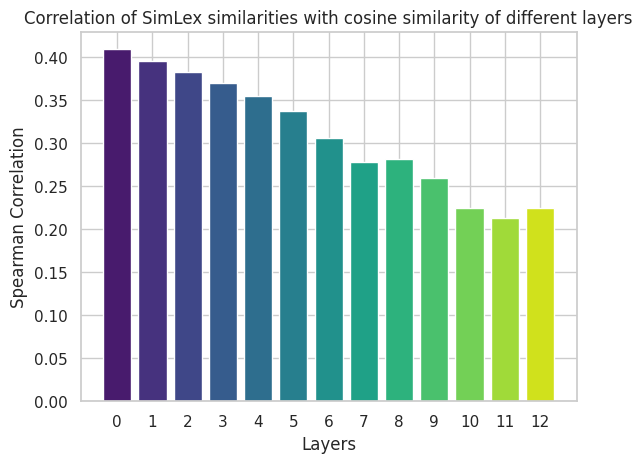

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

correlations = []

# Collect the correlations for each layer
for layer_num in range(13):  # For RobBERT base models, there are 13 layers including the output layer
    correlation, _ = spearmanr(simlex['SimLex999'], simlex[f'predicted_similarity_layer_{layer_num}'])
    correlations.append(correlation)

# Create a figure and axis
fig, ax = plt.subplots()

# Set colors for the layers
colors = sns.color_palette("viridis", len(correlations))

# Bar plot for the layers
ax.bar(range(len(correlations)), correlations, color=colors)

# Set the title and labels
ax.set_title('Correlation of SimLex similarities with cosine similarity of different layers')
ax.set_xlabel('Layers')
ax.set_ylabel('Spearman Correlation')

# Set the xticks to be the layer numbers
ax.set_xticks(range(len(correlations)))
ax.set_xticklabels(range(len(correlations)))

# Show the plot
plt.show()


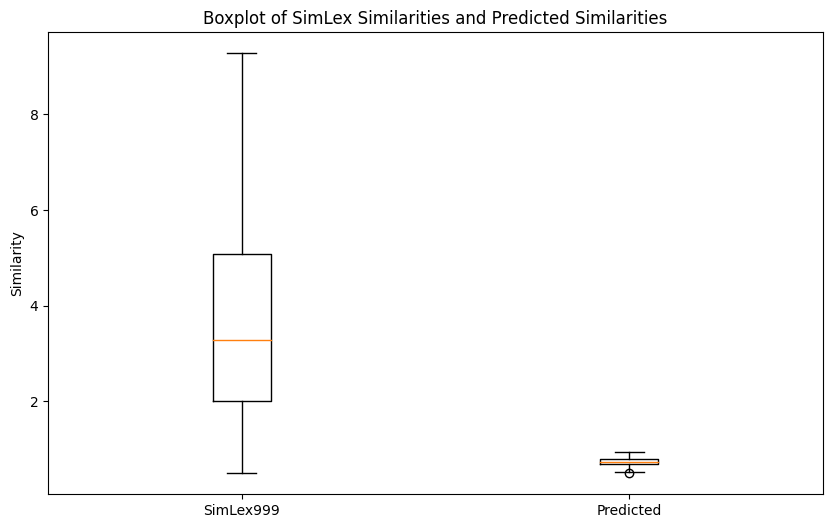

In [ ]:
plt.figure(figsize=(10,6))
plt.boxplot([simlex['SimLex999'], simlex['predicted_similarity_layer_12']], labels=['SimLex999', 'Predicted'])
plt.title('Boxplot of SimLex Similarities and Predicted Similarities')
plt.ylabel('Similarity')
plt.show()


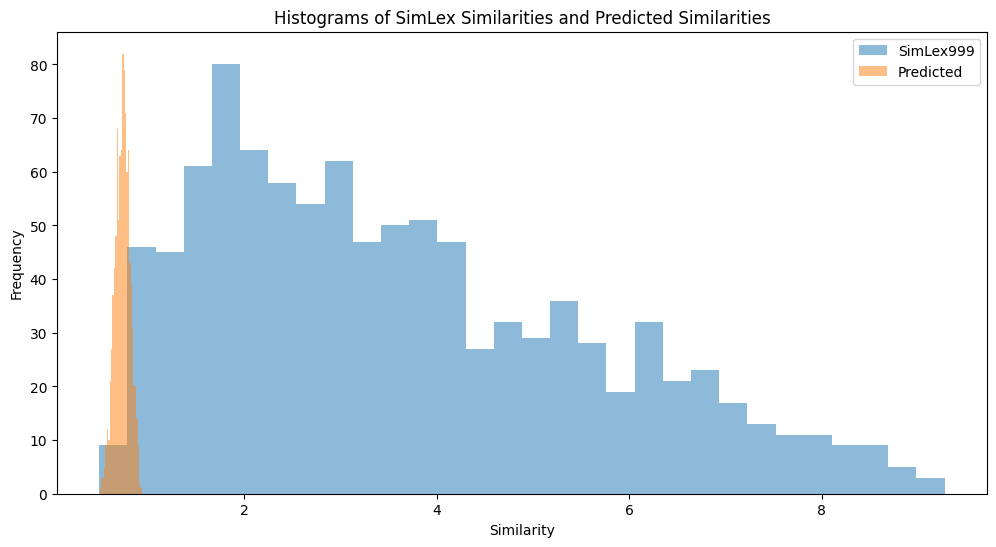

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(simlex['SimLex999'], bins=30, alpha=0.5, label='SimLex999')
plt.hist(simlex['predicted_similarity_layer_12'], bins=30, alpha=0.5, label='Predicted')
plt.title('Histograms of SimLex Similarities and Predicted Similarities')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


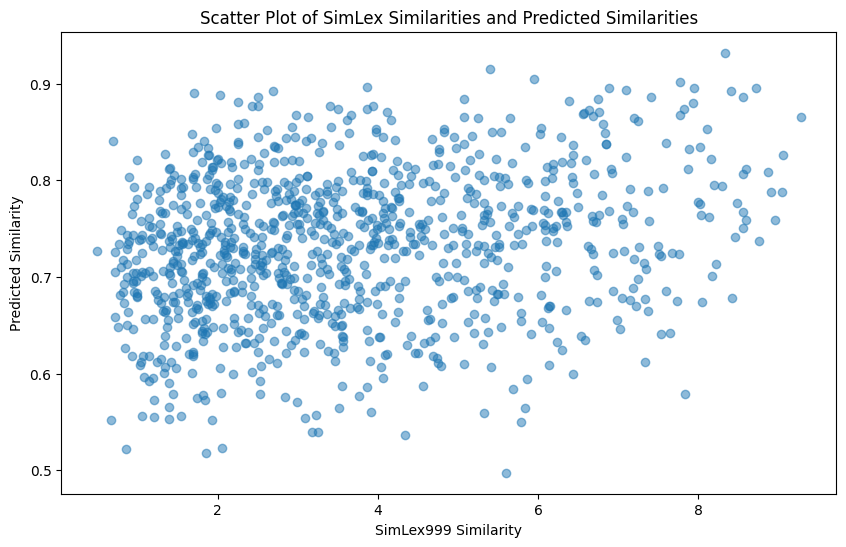

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(simlex['SimLex999'], simlex['predicted_similarity_layer_12'], alpha=0.5)
plt.title('Scatter Plot of SimLex Similarities and Predicted Similarities')
plt.xlabel('SimLex999 Similarity')
plt.ylabel('Predicted Similarity')
plt.show()


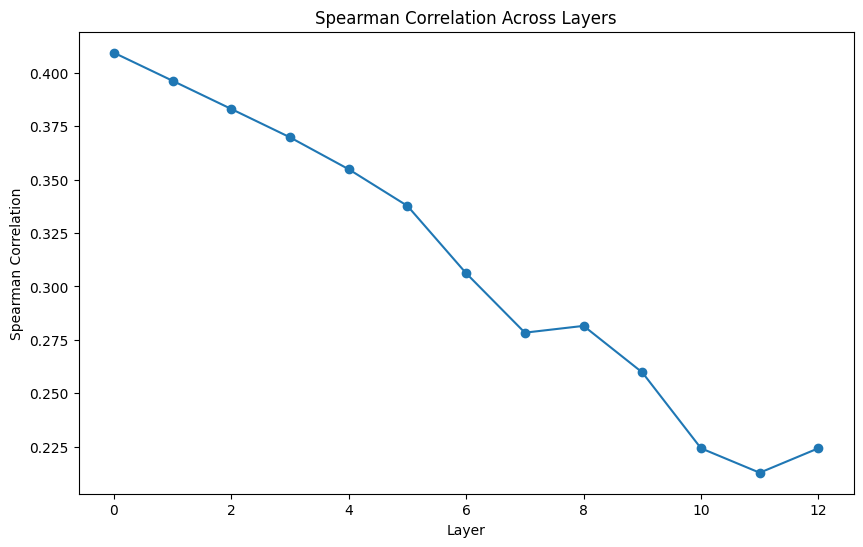

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(correlations, marker='o')
plt.title('Spearman Correlation Across Layers')
plt.xlabel('Layer')
plt.ylabel('Spearman Correlation')
plt.show()


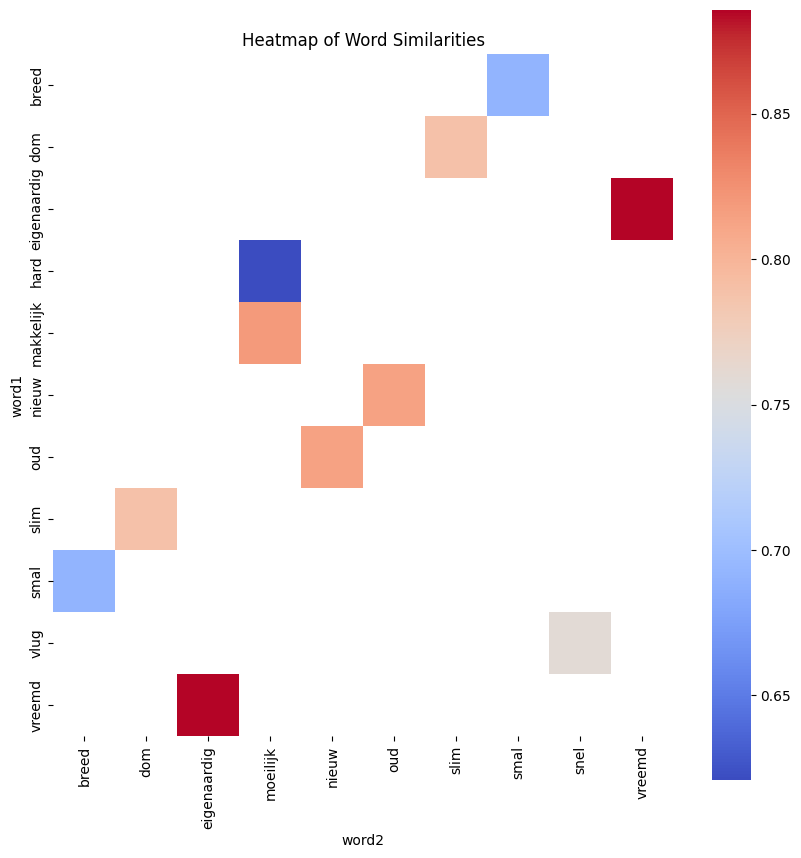

In [ ]:
# Select a subset of words
subset_words = simlex['word1'].unique()[:20]  # adjust this to your needs

# Filter the dataframe to include only the subset of words
subset_simlex = simlex[(simlex['word1'].isin(subset_words)) & (simlex['word2'].isin(subset_words))]

# Pivot the filtered dataframe to create a similarity matrix
similarity_matrix = subset_simlex.pivot(index='word1', columns='word2', values='predicted_similarity_layer_12')

# Plot the heatmap
plt.figure(figsize=(10,10))
sns.heatmap(similarity_matrix, cmap='coolwarm', square=True)
plt.title('Heatmap of Word Similarities')
plt.show()


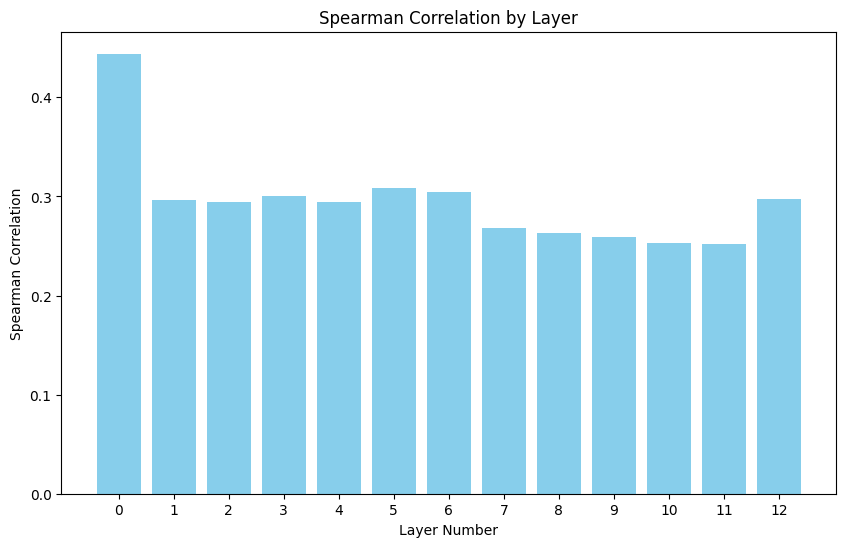

In [ ]:
import matplotlib.pyplot as plt

# Assume that we stored the Spearman correlation results in a list:
# (this is just an example, replace it with your actual results)
spearman_results = [0.444, 0.296, 0.294, 0.300, 0.294, 0.308, 0.304, 0.268, 0.263, 0.259, 0.253, 0.252, 0.297]

plt.figure(figsize=(10,6))
plt.bar(range(13), spearman_results, color='skyblue')

plt.xlabel('Layer Number')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation by Layer')
plt.xticks(range(13))

plt.show()


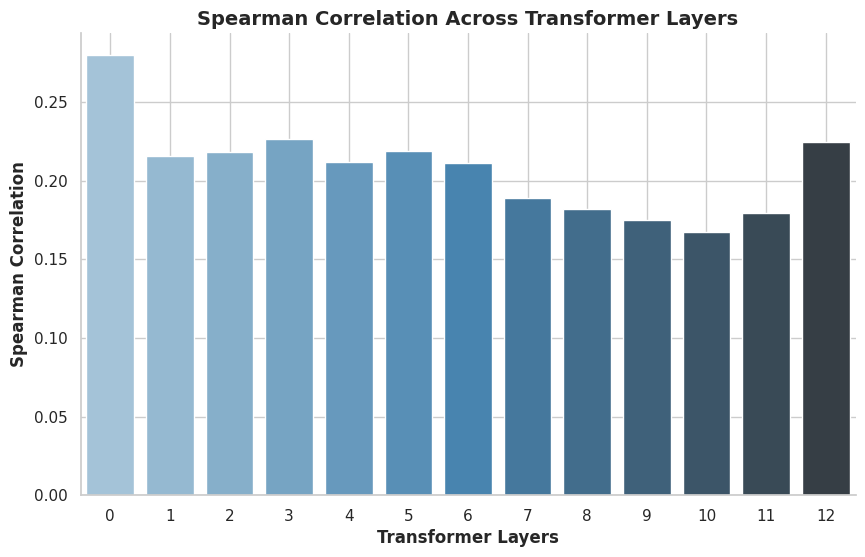

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving plot aesthetics using Seaborn
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting data
ax = sns.barplot(x=list(range(13)), y=spearman_results, palette="Blues_d", ax=ax)

# Adding title and labels
ax.set_title('Spearman Correlation Across Transformer Layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Transformer Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')

# Adding a grid
ax.grid(True)

# Remove top and right borders
sns.despine()

plt.show()


AttributeError: ignored

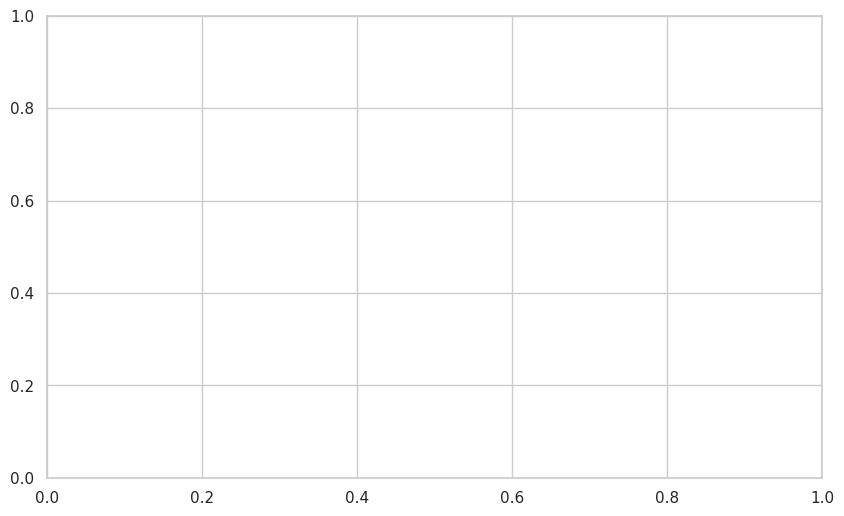

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving plot aesthetics using Seaborn
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting data with edgecolor
ax = sns.barplot(x=list(range(13)), y=correlations, palette="Blues_d", ax=ax, edgecolor='black')

# Adding title and labels
ax.set_title('Correlation of SimLex similarities with cosine similarity of different layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')

# Adding a grid
ax.grid(True)

# Remove top and right borders
sns.despine()

plt.show()


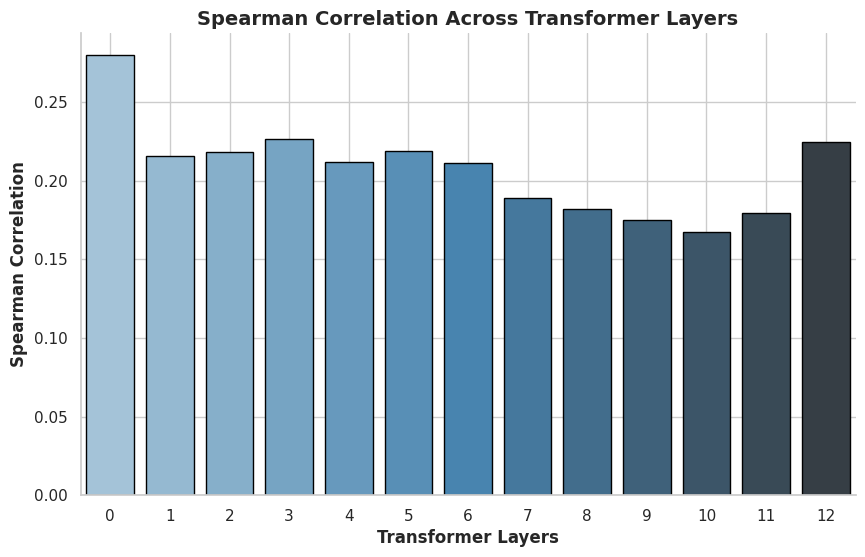

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving plot aesthetics using Seaborn
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting data with edgecolor
ax = sns.barplot(x=list(range(13)), y=spearman_results, palette="Blues_d", ax=ax, edgecolor='black')

# Adding title and labels
ax.set_title('Spearman Correlation Across Transformer Layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Transformer Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')

# Adding a grid
ax.grid(True)

# Remove top and right borders
sns.despine()

plt.show()


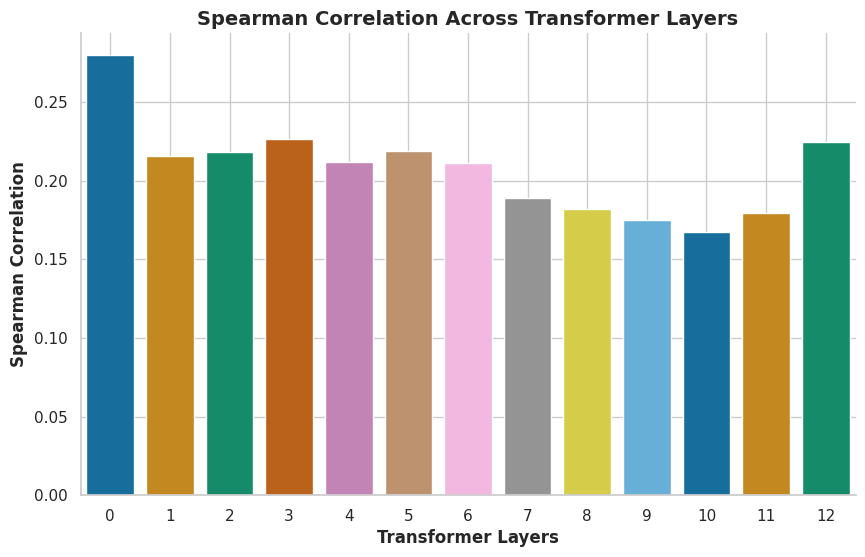

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving plot aesthetics using Seaborn
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting data
ax = sns.barplot(x=list(range(13)), y=spearman_results, palette="colorblind", ax=ax)

# Adding title and labels
ax.set_title('Spearman Correlation Across Transformer Layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Transformer Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')

# Adding a grid
ax.grid(True)

# Remove top and right borders
sns.despine()

plt.show()


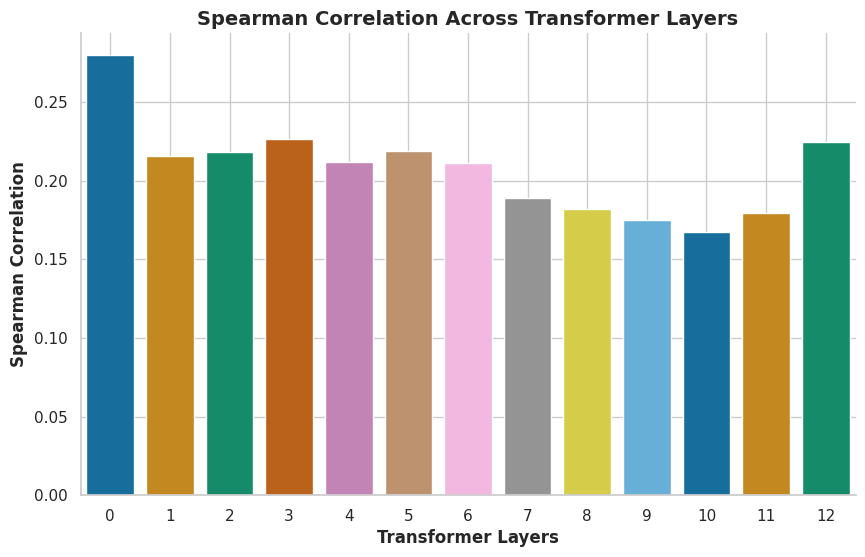

In [ ]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=list(range(13)), y=spearman_results, palette="colorblind", ax=ax)
ax.set_title('Spearman Correlation Across Transformer Layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Transformer Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')
ax.grid(True)
sns.despine()
plt.show()

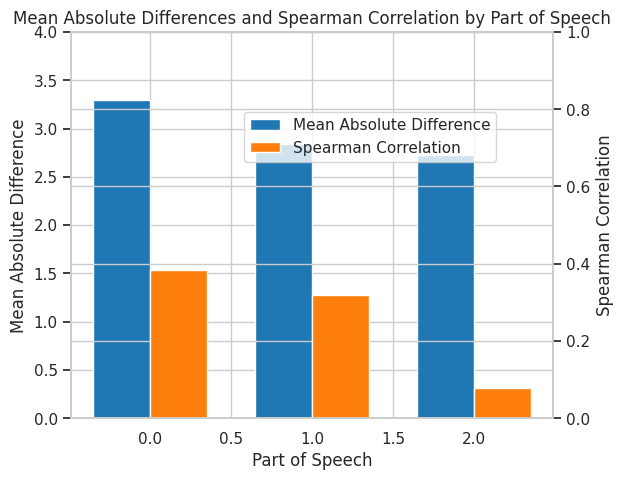

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'grouped' and 'spearman_corr' are your data
grouped = {'A': 3.297623, 'N': 2.835776, 'V': 2.725618}
spearman_corr = {'A': 0.38389480242547624, 'N': 0.3195469653921415, 'V': 0.0793393737137762}

# Prepare data for the plot
labels = grouped.keys()
mean_diffs = grouped.values()
correlations = spearman_corr.values()

# Prepare the plot
x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots()

# Create the bars for mean differences
rects1 = ax1.bar(x - width/2, mean_diffs, width, label='Mean Absolute Difference', color='tab:blue')
ax1.set_ylabel('Mean Absolute Difference')
ax1.set_xlabel('Part of Speech')
ax1.set_ylim([0, 4])  # Set the y-axis limits

# Create a second y-axis for the correlations
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, correlations, width, label='Spearman Correlation', color='tab:orange')
ax2.set_ylabel('Spearman Correlation')
ax2.set_ylim([0, 1])  # Set the y-axis limits

# Create the legend and title
fig.tight_layout()
handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.8, 0.8))
plt.title('Mean Absolute Differences and Spearman Correlation by Part of Speech')


# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Data to plot
labels = pos_counts.keys()
sizes = pos_counts.values()

# Colors - choosing a colorblind-friendly palette
colors = ['#E69F00','#56B4E9','#009E73']

# Plot
fig, ax = plt.subplots(figsize=(8,8))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Adding a title and improving the labels
plt.title('Proportional Distribution of Word Categories', fontsize=18)
ax.legend(wedges, labels, title='Categories', loc='upper right', bbox_to_anchor=(1, 0, 0.5, 1))

# Changing the fontsize of the labels and percentages
plt.setp(autotexts, size=15, weight='bold')
plt.setp(texts, size=15)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.show()


TypeError: ignored

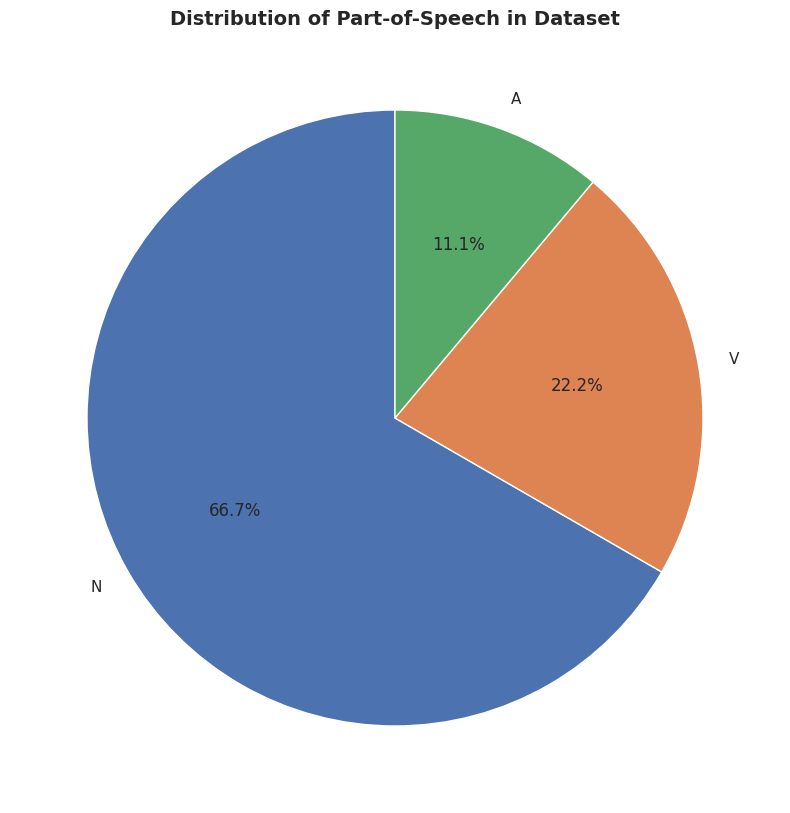

In [ ]:
import matplotlib.pyplot as plt

# Calculate POS frequencies
pos_counts = simlex['POS'].value_counts()

# Plot a pie chart
plt.figure(figsize=(10,10))
plt.pie(pos_counts, labels=pos_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Part-of-Speech in Dataset', fontsize=14, fontweight='bold')
plt.show()


AttributeError: ignored

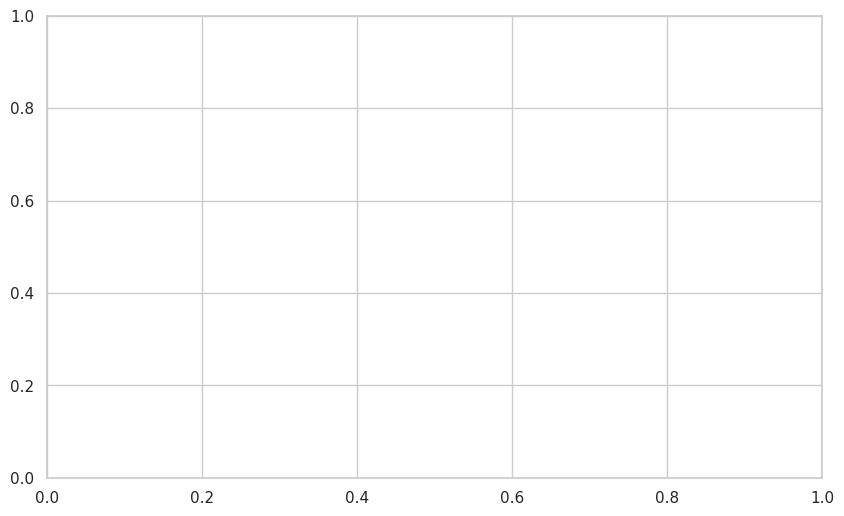

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving plot aesthetics using Seaborn
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting data with edgecolor
ax = sns.barplot(x=list(range(13)), y=correlations, palette="Blues_d", ax=ax, edgecolor='black')

# Adding title and labels
ax.set_title('Correlation of SimLex similarities with cosine similarity of different layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')

# Adding a grid
ax.grid(True)

# Remove top and right borders
sns.despine()

plt.show()
